<h1 style="font-size:35px;
        color:black;
        ">Lab 4 Iterative Phase Estimation Algorithm</h1>

Prerequisite
- [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)
- [Ch.1.4 Single Qubit Gates](https://qiskit.org/textbook/ch-states/single-qubit-gates.html)
- [Summary of Quantum Operations](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html)
- [Qiskit circuit library - QFT](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html#qiskit.circuit.library.QFT)

Other relevant materials
- [Device backend noise model simulations](https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html)
- [Hellinger fidelity](https://qiskit.org/documentation/stubs/qiskit.quantum_info.hellinger_fidelity.html#qiskit.quantum_info.hellinger_fidelity)

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
import matplotlib.pyplot as plt

In [2]:
sim = Aer.get_backend('aer_simulator')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<h2 style="font-size:24px;">Part 1: Implementation of Iterative Phase Estimation algorithm</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Estimate a phase value on a system of two qubits through Iterative Phase Estimation (IPE) algorithm.</p>
</div>

Having gone through previous labs, you should have noticed that the "length" of a quantum circuit is the primary factor when determining the magnitude of the errors in the resulting output distribution; quantum circuits with greater depth have decreased fidelity.  Therefore, implementing algorithms based on shallow depth circuits is of the great importance in near-term quantum computing. In Lab 4, we learn one such algorithm for estimating quantum phase called the Iterative Phase Estimation (IPE) algorithm which requires a system comprised of only a single auxiliary qubit and evaluate the phase through a repetitive process. 

<h3 style="font-size: 20px">1. Understand a circuit with non-unitary operations.</h3>

Before we learn how the IPE algorithm works, lets review reset and conditional operations in Qiskit that go into building a IPE circuit. Read the Qiskit tutorial [here](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html) ( go to `Non-unitary operations` section ) to understand how to build a circuit that performs conditional operations and reset.

<h4 style="font-size: 17px">&#128211;Step A. Run the following cell and predict the outcome of the circuit. </h4>

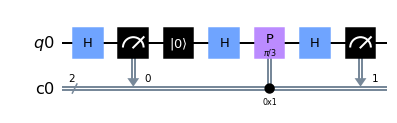

In [3]:
q = QuantumRegister(1)
c = ClassicalRegister(2)

qc0 = QuantumCircuit(q, c)
qc0.h(q[0])
qc0.measure(q[0], c[0])
qc0.reset(q[0])
qc0.h(q[0])
qc0.p(np.pi/3, q[0]).c_if(c,1)
qc0.h(q[0])
qc0.measure(q[0],c[1])

qc0.draw()

Execute the cell below to see the result.

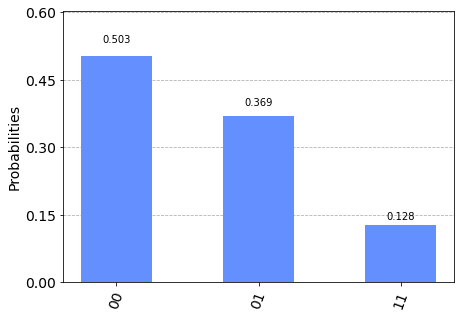

In [4]:
qc0 = transpile(qc0, sim)
count0 = sim.run(qc0).result().get_counts()
plot_histogram(count0)

<h4 style="font-size: 17px">&#128211;Step B. Complete the rest of the circuit so that the auxiliary qubit ( top qubit ) after the reset would be in the state $\frac{1}{\sqrt2}(|0\rangle + e^{-i\frac{\pi}{2}}|1\rangle)$ if the value of the classical bit is one or remains zero state otherwise.</h4>

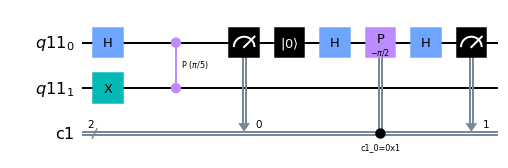

In [5]:
q = QuantumRegister(2)
c = ClassicalRegister(2)

qc1 = QuantumCircuit(q,c)
qc1.h(q[0])
qc1.x(q[1])
qc1.cp(np.pi/5, q[0], q[1])
qc1.measure(q[0], c[0])
qc1.reset(q[0])

###### your code goes here #####

qc1.h(q[0])
qc1.p(-np.pi/2, q[0]).c_if(c[0],1)

##########################
qc1.h(q[0])
qc1.measure(q[0],c[1])

qc1.draw()

Running the following cell to display the result.

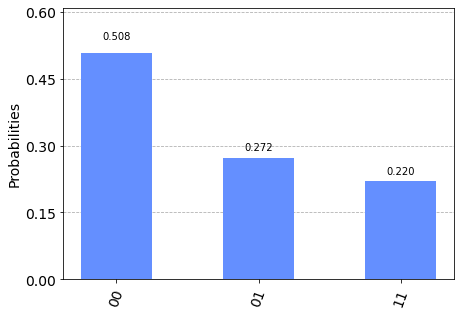

In [6]:
qc1 = transpile(qc1, sim)
count1 = sim.run(qc1).result().get_counts()
plot_histogram(count1)

<h3 style="font-size: 20px">2. Iterative Phase Estimation (IPE) Algorithm.</h3>

The Quantum Phase Estimation (QPE) circuit that we have learned and used previously is limited by the number of qubits necessary for the algorithm’s precision.  Every additional qubit has added costs in terms of noise and hardware requirements; noisy results that we obtained from executing the QPE circuit on a real quantum device in Lab 3 would get worse as the number of the qubits on the circuit increases. The IPE algorithm implements quantum phase estimation with only a single auxiliary qubit, and the accuracy of the algorithm is restricted by the number of iterations rather than the number of counting qubits. Therefore, IPE circuits are of practical interest and are of foremost importance for near-term quantum computing as QPE is an essential element in many quantum algorithms.

Consider the problem of finding $\varphi$ given $|\Psi\rangle$ and $U$ such that $U |\Psi\rangle = e^{i \phi} | \Psi \rangle$, with $\phi = 2 \pi \varphi$. Let's assume for now that $\varphi$ can be written as $\varphi = \varphi_1/2 + \varphi_2/4 + ... + \varphi_m/2^m = 0.\varphi_1 \varphi_2 ... \varphi_m$, where we have previously defined the notation $0.\varphi_1 \varphi_2 ... \varphi_m$. 

Assume that $U$ is a unitary operator acting on one qubit. We therefore need a system of two qubits, $q_0$ and $q_1$, where $q_0$ is auxiliary qubit and the qubit $q_1$ represents the physical system on which $U$ operates. Having them initialized as $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$, application of control-U between $q_0$ and $q_1$ $2^t$ times would change the state of $q_0$ to $|0\rangle + e^{i 2 \pi 2^{t} \varphi} | 1 \rangle$. That is, the phase of $U$ has been kicked back into $q_0$ as many times as the control operation has been performed.

Therefore, 

for $t=0$, the phase encoded into $q_0$ would be $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$
and 

for $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi} = e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$ and

for $t=2$, $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 2 \varphi_1} e^{i 2 \pi \varphi_2} e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$
and 

for $t=m-1$, $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 2^{m-2} \varphi_1} e^{i 2 \pi 2^{m-3} \varphi_2} ... e^{i 2 \pi 2^{-1} \varphi_m} = e^{i 2 \pi 0.\varphi_m}$. 

Note that for the last case with $t=m-1$, the state of $q_0$ is $|0\rangle + e^{i 2 \pi 0.\varphi_m}|1\rangle$; $|+\rangle$ if $\varphi_m = 0$ and $|-\rangle$ if $\varphi_m = 1$ which would produce outcomes $|0\rangle$ and $|1\rangle$ respectively when it gets measured in x-basis. 

In `the first step` of the IPE algorithm, we directly measure the least significant bit of the phase $\varphi$, $\varphi_m$, by initializing the 2-qubit registers as described above ( $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$ ), performing $2^{m-1}$ control-$U$ operations between the qubits, and measuring $q_0$ in the x-basis.

For `the second step`, we initialize the systems in the same way and apply $2^{m-2}$ control-$U$ operations. The relative phase in $q_0$ after these operations is now $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. 
To extract the phase bit $\varphi_{m-1}$, first perform a phase correction by rotating around the $Z-$axis of angle $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, which results in the state of  $q_0$ to be $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. Perform a measurement on $q_0$ in x-basis to obtain the phase bit $\varphi_{m-1}$. 

Therefore, the $k$th step of the IPE, getting $\varphi_{m-k+1}$, consists of the register initialization ($q_0$ in $|+\rangle$, $q_1$ in $|\Psi\rangle$), the application of control-$U$ $2^{m-k}$ times, a rotation around $Z$ of angle $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$, and a measurement of $q_0$ in x-basis: a Hadamard transform to $q_0$, and a measurement of $q_0$ in the standard basis. Note that $q_1$ remains in the state $|\Psi\rangle$ throughout the algorithm.

<h3 style="font-size: 20px">3. Estimate the phase of the $T$-gate implementing IPE algorithm.</h3>

Review the `section 2. Example: T-gate` in [Ch.3.8 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html) and the `section 4. Measuring in Different Bases` in [Ch.1.4 Single Qubit Gates](https://qiskit.org/textbook/ch-states/single-qubit-gates.html) 

As we already learned the Qiskit textbook, the phase of a T-gate is exactly expressed using three bits.

<h4 style="font-size: 17px">&#128211;Step A. Obtain the least significant phase bit of the $T$-gate by setting up the circuit <code>T_x3</code> properly and assign the value to the variable <code>x_3</code>.</h4>

In the previous section, `the first step` explains how to construct the circuit to extract the least significant phase bit. 

x_3 = 1


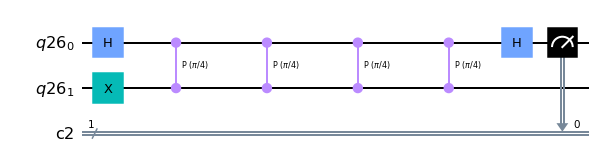

In [7]:
m = 3 # bit menos significativo
q = QuantumRegister(2)
c = ClassicalRegister(1)

T_x3 = QuantumCircuit(q,c)

########## your code goes here #######

##1 Initialization
T_x3.reset(q)
T_x3.h(q[0])
T_x3.x(q[1])

#2 Apply control-U operator as many times as needed to get the least significant phase bit

def t_gate(circuit, first_qubit, second_qubit):
    circuit.cp(np.pi/4, first_qubit, second_qubit)

for i in range(2**(m-1)):
    t_gate(T_x3, q[0], q[1])
    


#3 measure the anscillar qubit in x-basis
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

x_measurement(T_x3, q[0], c[0])

########## Simulate the circuit and assign the output value to the variable 'x_3' 
T_x3 = transpile(T_x3)
job = sim.run(T_x3, shots=1, memory=True)
x_3 = int(job.result().get_memory()[0])

print('x_3 = {}'.format(x_3))
T_x3.draw('mpl')

<h4 style="font-size: 17px">&#128211;Step B. Extract the middle phase bit of the $T$-gate by creating the circuit <code>T_x2</code> with phase correction using <code>x_3</code> value from Step A. Assign the outcome bit to the variable <code>x_2</code>.</h4>

Read the `the second step` in the previous section. 

x_2 = 0


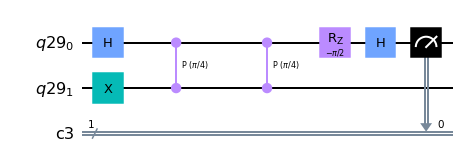

In [8]:
q = QuantumRegister(2)
c = ClassicalRegister(1)

T_x2 = QuantumCircuit(q,c)

########## your code goes here #######

##1 Initialization
T_x2.reset(q)
T_x2.h(q[0])
T_x2.x(q[1])

#2 Apply control-U operator as many times as needed to get the middle significant phase bit
for i in range(2**(m-2)):
    t_gate(T_x2, q[0], q[1])
    
T_x2.rz(-np.pi*x_3/2, q[0]) # *x_3 is the same thing as c_if

##3 measure the anscillar qubit in x-basis
x_measurement(T_x2, q[0], c[0])

########## Simulate the circuit and assign the output value to the variable 'x_3' 
T_x2 = transpile(T_x2)
job = sim.run(T_x2, shots=1, memory=True)
x_2 = int(job.result().get_memory()[0])

print('x_2 = {}'.format(x_2))
T_x2.draw('mpl')

<h4 style="font-size: 17px">&#128211;Step C. Find the most significant phase bit of the $T$-gate and assign it to the variable <code>x_1</code>. </h4>

x_1 = 0


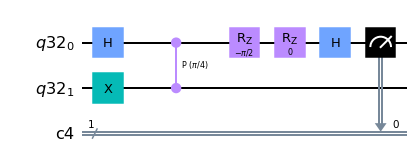

In [9]:
q = QuantumRegister(2)
c = ClassicalRegister(1)

T_x1 = QuantumCircuit(q,c)

########## your code goes here #######

##1 Initialization
T_x1.reset(q)
T_x1.h(q[0])
T_x1.x(q[1])

#2 Apply control-U operator as many times as needed to get the most significant phase bit
for i in range(2**(m-3)):
    t_gate(T_x1, q[0], q[1])

T_x1.rz(-np.pi*x_3/2, q[0]) # *x_3 is the same thing as c_if
T_x1.rz(-np.pi*x_2/4, q[0]) # *x_2 is the same thing as c_if

##3 measure the anscillar qubit in x-basis
x_measurement(T_x1, q[0], c[0])

########## Simulate the circuit and assign the output value to the variable 'x_3' 
T_x1 = transpile(T_x1)
job = sim.run(T_x1, shots=1, memory=True)
x_1 = int(job.result().get_memory()[0])

print('x_1 = {}'.format(x_1))
T_x1.draw('mpl')

Therefore, the $T$-gate phase bit that you found is 0.x_1x_2x_3. Run the following cell to check if your answer is correct by comparing your phase bit `x_1x_2x_3` with `001`, the answer in the Qiskit textbook, which corresponds to $\frac{1}{8}$ ( = `0.125`), the phase of the $T$-gate.

In [10]:
T_phase_bits = '{}{}{}'.format(x_1, x_2, x_3) 
T_phase_bits == '001'

True

<h4 style="font-size: 17px">&#128211;Step D. Construct the full IPE circuit and pass it to the variable <code>qc_T</code> ; Put the all steps that you performed into one circuit utilizing conditional operations and reset. </h4>

Instead of using three separate circuits to extract each phase bit value, build one circuit; perform a reset operation on the auxiliary qubit after each bit gets measured into a classical register. Therefore, the circuit requires three classical registers for this example; the least significant bit measured into the classical register, c[0] and the most significant bit measured into c[2]. Implement conditional operator between the auxiliary qubit and the classical register for the phase correction. 

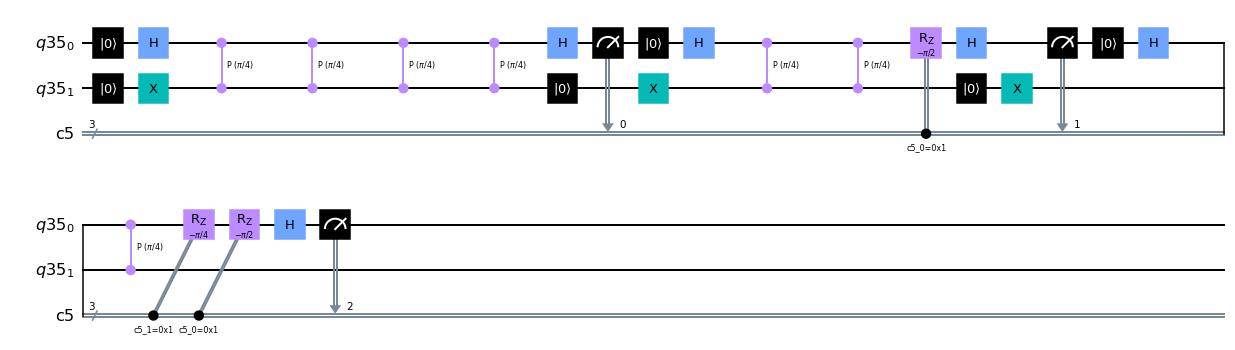

In [11]:
##### your code goes here ######
q = QuantumRegister(2)
c = ClassicalRegister(3)

qc_T = QuantumCircuit(q,c)

m = 3 # number of classical bits necessary to express the T-gate phase

for k in range(m):
    qc_T.reset(q)
    qc_T.h(q[0])
    qc_T.x(q[1])
    diff = m-k

    repetitions_for_this_bit = 2**(diff-1)

    for repetition in range(repetitions_for_this_bit):
        t_gate(qc_T, q[0], q[1])
    
    if k > 0:
        for predecessor in range(k):
            qc_T.rz(-np.pi*2**(predecessor-k),0).c_if(c[k-predecessor-1],1)
    
    x_measurement(qc_T, q[0], c[k])


qc_T.draw('mpl')
# c = [0, 0, 1]

<h4 style="font-size: 17px">Step E. Execute the following cell to perform the simulation and display the result.</h4>

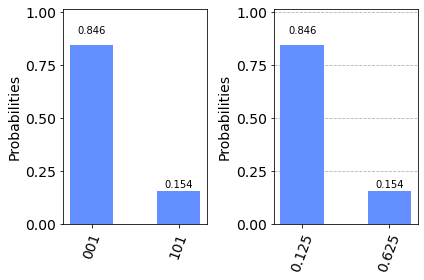

In [12]:
qc_T = transpile(qc_T, sim)
count0 = sim.run(qc_T).result().get_counts()

key_new = [str(int(key,2)/2**3) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

<h2 style="font-size:24px;">Part 2: Comparison between QPE and IPE results in the presence of noise</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Understand the importance of implementing shallow circuit algorithms on current noisy quantum computers.  </p>
</div>

In Part 2 of Lab 3, we executed a Quantum Phase Estimation (QPE) circuit on a real quantum device.  Having recognized the limits of the performance due to noise that presents in current quantum system, we utilized several techniques to reduce its influence on the outcome. However, the final result that was obtained, even after all these procedures, is still far from ideal. Here, we implement Iterative Phase Estimation (IPE) algorithm to overcome the effect of noise in phase estimation to a great extent and compare the result with the QPE outcome. 

To investigate the impact of the noise from real quantum system on the outcome, we will perform noisy simulations of IPE circuit employing the Qiskit Aer `noise` module which produces a simplified noise model for an IBM quantum system. To learn more about noisy simulation, read [here](https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html).  

As in Lab 3, we consider to estimate the phase of `p` gate with $\theta = \frac{1}{3}$. Suppose that the accuracy of the estimation that we desire here is same as when the QPE circuit has four counting qubits, which determines the number of iteration and classical registers required for the IPE circuit.

<h4 style="font-size: 17px">&#128211;Step A. How many classical registers is needed? Assign the value to the variable <code>n</code>.  </h4>

In [13]:
## your answer goes here
n = 4

<h4 style="font-size: 17px">&#128211;Step B. Construct the IPE circuit in the following cell. </h4>

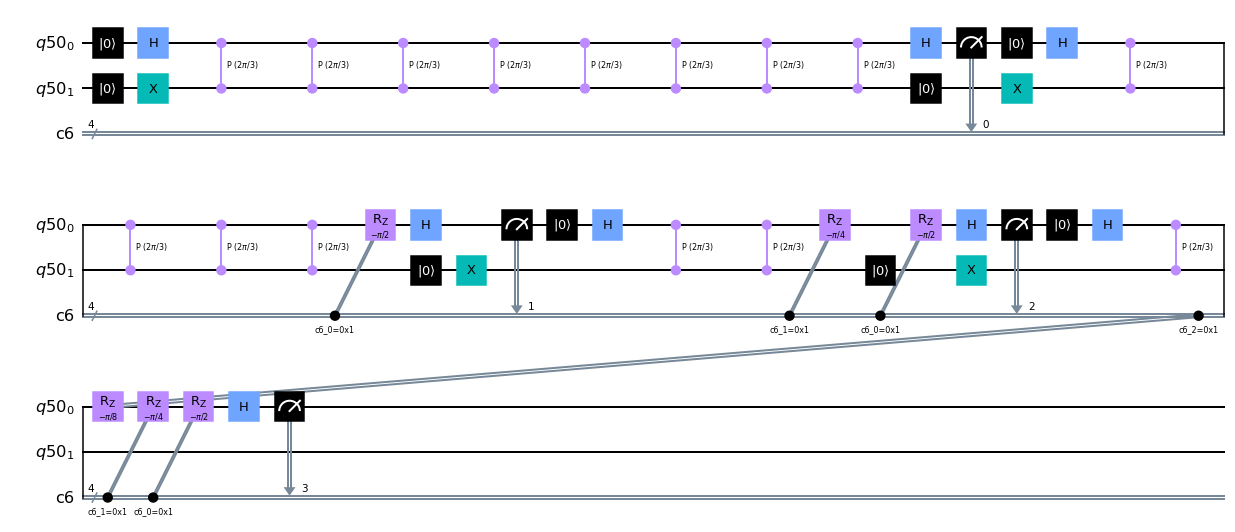

In [14]:
q = QuantumRegister(2)
c = ClassicalRegister(n)

IPE = QuantumCircuit(q,c)

########## your code goes here ############

def p_gate(circuit, first_qubit, second_qubit):
    circuit.cp(2*np.pi/3, first_qubit, second_qubit)


for k in range(n):
    IPE.reset(q)
    IPE.h(q[0])
    IPE.x(q[1])
    diff = n-k
    
    # repete 2^(m-1)
    repetitions_for_this_bit = 2**(diff-1)
    
    for repetition in range(repetitions_for_this_bit):
        p_gate(IPE, q[0], q[1])
    
    # z correction
    if k > 0:
        for predecessor in range(k):
            IPE.rz(-np.pi*2**(predecessor-k),0).c_if(c[k-predecessor-1],1)
    
    x_measurement(IPE, q[0], c[k])


#####################
IPE.draw()

Run the cell below to obtain the result.

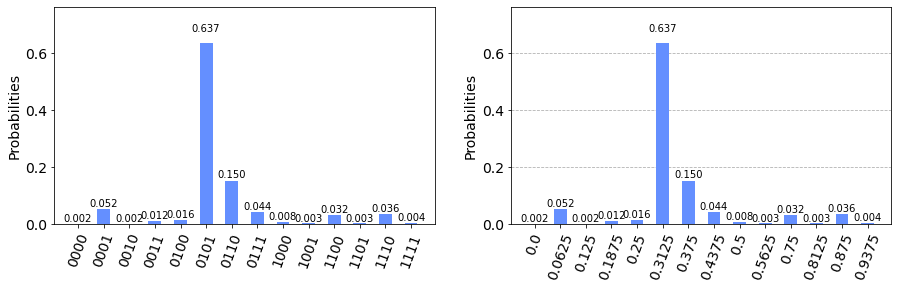

In [15]:
IPE = transpile(IPE, sim)
count_tmp= sim.run(IPE).result().get_counts()
key_new = [str(int(key,2)/2**n) for key in list(count_tmp.keys())]
count_new = dict(zip(key_new, count_tmp.values()))

fig, ax = plt.subplots(1,2, figsize=(15, 4))
plot_histogram(count_tmp, ax=ax[0])
plot_histogram(count_new, ax=ax[1])

<h4 style="font-size: 17px">Step C. Run the cell below to create the QPE circuit for the comparison. </h4>

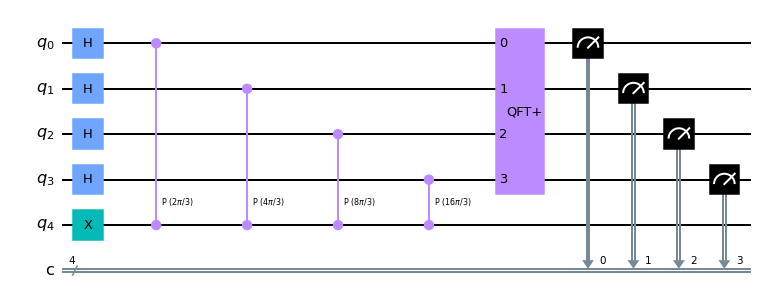

In [23]:
def QFT(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


# define the parameters
t, psi = 4, 1/3*np.pi*2

# building a circuit
QPE = QuantumCircuit(t+1,t)
QPE.h(range(t))
QPE.x(t)
for idx in range(t):
    QPE.cp(psi*2**idx, idx, t)
    
qft_dag = QFT(t).to_gate().inverse()
qft_dag.label = 'QFT+'
QPE.append(qft_dag, range(t))
QPE.measure(range(t), range(t))

QPE.draw()

<h4 style="font-size: 17px">&#128211;Step D. Transpile the circuits for the backend <code>ibmq_vigo</code>. </h4>

Run the following cell to check the properties of the backend, `ibmq_vigo`. Pick an initial_layout, and transpile the IPE circuit setting `optimization_level` = 3, and save the transpiled circuit to the variable `IPE_trans`. Print out the depth of the transpiled circuit.

In [24]:
from qiskit.test.mock import FakeAthens
import qiskit.tools.jupyter

backend = FakeAthens()
backend;

In [25]:
######## your code to transpile IPE circuit goes here ########
num = 500
IPE_trans = transpile([IPE]*num, backend, optimization_level=3)
IPE_trans_depth = np.array([IPE_trans[idx].depth() for idx in range(num)])
print(min(IPE_trans_depth), max(IPE_trans_depth))
best_arg = np.argmin(IPE_trans_depth)
IPE_trans = IPE_trans[best_arg]
#####################
print(IPE_trans.depth())


52 52
52


Execute the cell below to transpile QPE circuit. 

In [26]:
num = 500
QPE_trans = transpile([QPE]*num, backend, optimization_level=3)
QPE_trans_depth = np.array([QPE_trans[idx].depth() for idx in range(num)])
print(min(QPE_trans_depth), max(QPE_trans_depth))
best_arg = np.argmin(QPE_trans_depth)
QPE_trans_best = QPE_trans[best_arg]

63 83


<h4 style="font-size: 17px">Step E. Run the following cells to perform the noise simulation of the transpiled circuits.  </h4>

In [27]:
from qiskit.providers.aer.noise import NoiseModel

noise_model = NoiseModel.from_backend(backend)
shots = 20000

counts = execute([IPE_trans, QPE_trans_best], sim, noise_model=noise_model).result().get_counts()

<h4 style="font-size: 17px">Step F. Execute the cell below to compute the exact phase estimation results. </h4>

In [28]:
from qiskit.quantum_info import Statevector

QPE_exact = QuantumCircuit(t+1)
QPE_exact.h(range(t))
QPE_exact.x(t)
for idx in range(t):
    QPE_exact.cp(psi*2**idx, idx, t)
    
qft_dag = QFT(t).to_gate().inverse()
qft_dag.label = 'QFT+'
QPE_exact.append(qft_dag, range(t))

state = Statevector.from_instruction(QPE_exact)
pmf = state.probabilities_dict(range(4))
#QPE_exact.draw('mpl')

<h4 style="font-size: 17px">Step G. Show the comparison figure by running the following cell.</h4>

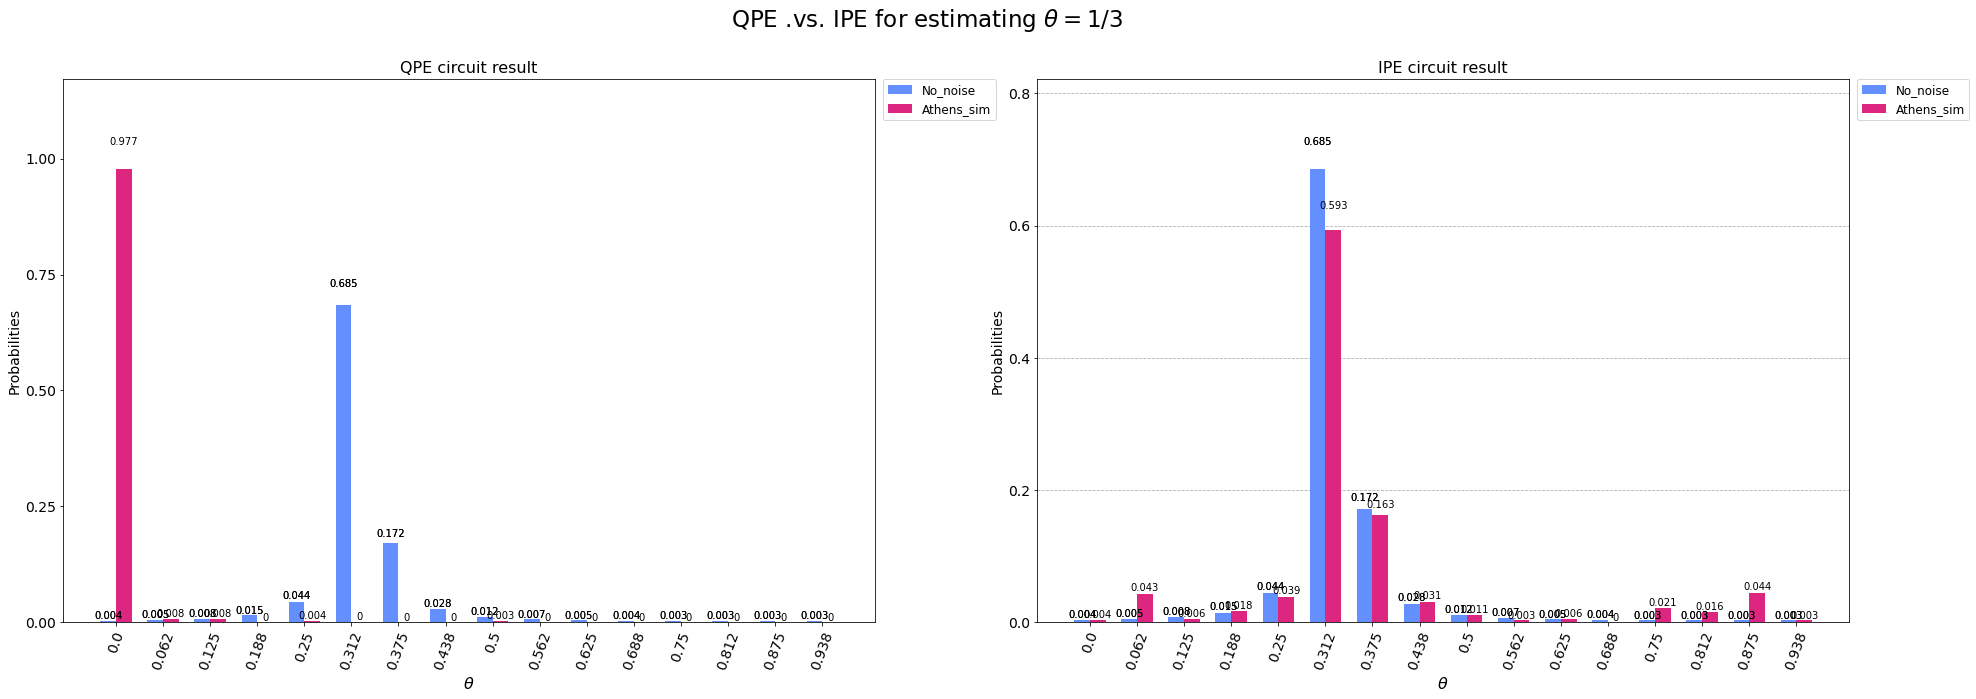

In [29]:
def count_new(count):
    phi_est = np.array([round(int(key, 2)/2**t, 3) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

pmf_new = count_new(pmf)
count_IPE = count_new(counts[0])
count_QPE = count_new(counts[1])

fig, ax = plt.subplots(1, 2, figsize=(32,10))
fig.suptitle('QPE .vs. IPE for estimating $\\theta=1/3$', fontsize=23)
plot_histogram([pmf_new, count_QPE], ax=ax[0], legend=['No_noise', 'Athens_sim'])
plot_histogram([pmf_new, count_IPE], ax=ax[1], legend=['No_noise', 'Athens_sim'])
ax[0].set_title('QPE circuit result', fontsize=16)
ax[0].set_xlabel('$\\theta$', fontsize=16)
ax[1].set_title('IPE circuit result', fontsize=16)
ax[1].set_xlabel('$\\theta$', fontsize=16)
plt.show()

If you create the IPE circuit successfully to estimate the phase, $\theta = \frac{1}{3}$, you would get the similar plots as shown below. 

![](image/L4_QPEvsIPE.png)